# Masking

This notebook shows our case for implementing masks on the XRP dataset.

In [1]:
cd ..

/Users/azib/Documents/PhD/Exocomets/automated_exocomet_hunt


## Module imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import warnings
warnings.filterwarnings("ignore")
from scipy.stats import median_abs_deviation
from astropy.stats import sigma_clip,sigma_clipped_stats
from astropy.table import Table
from astropy.time import Time
#import ipympl
from tqdm import tqdm
%matplotlib inline
np.set_printoptions(threshold=np.inf)

### SPOcc files

In [3]:
import data 
import loaders

#### Reading in bad times data and MAD dataframe.

In [4]:
bad_times = data.load_bad_times()
bad_times = bad_times - 2457000
mad_df = data.load_mad()

### Functions

In [5]:
def import_XRPlightcurve(file_path):
    """
    Importing the compressed TESS lightcurves from the XRP group.
    file_path: path to file
    :type file_path: pkl
    :returns: 
        - lc - lightcurve data as a DataFrame. 
        - store - Storage of other information (TIC, RA, Dec, TESS magnitude, Camera, Chip)
    """
    data = pd.read_pickle(file_path)

    ## extracting the lightcurve data and converting to Series from lists
    for i in range(len(data)):
        if isinstance(data[i],np.ndarray):
            data[i] = pd.Series(data[i])
    for_df = data[6:] # data[0:6] is not relevant in this case.
    columns = ['time','raw flux','corrected flux','PCA flux','flux error','quality']
    df = pd.DataFrame(data=for_df).T
    df.columns = columns
    return df, data[0:6]

def normalise_lc(flux):
    return flux/flux.mean()


In [7]:
filename = 'tess/tesslc_4207261.pkl'
lc, store = import_XRPlightcurve(filename)
lc['normalised PCA'] = normalise_lc(lc['PCA flux'])

In [8]:
sec = 6 # int(filename.split('_')[2])
cam = store[4]
mad_arr = mad_df.loc[:len(lc)-1, f"{sec}-{cam}"]

In [154]:
mad_df = pd.read_json("./data/Sectors_MAD.json")

### First lightcurve

In [10]:
q = lc.quality == 0
len(lc['corrected flux'][q])
976/1282

0.7613104524180967

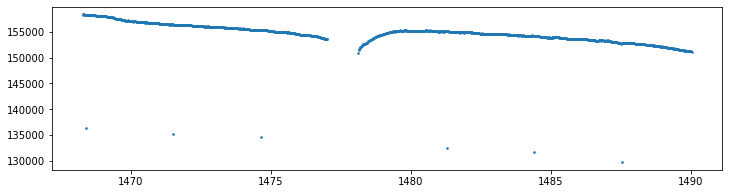

In [11]:
plt.figure(figsize=(12,3))
#lc['normalised PCA'][lc.quality==0].plot()
plt.scatter(lc['time'],lc['raw flux'],s=2.5)
#plt.ylim(340000,355000)
plt.show()

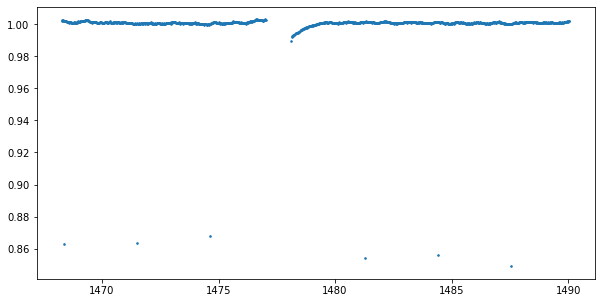

In [12]:
plt.figure(figsize=(10,5))
plt.scatter(lc['time'],lc['normalised PCA'],s=2.5)
plt.show()

## Testing MAD Thresholds

The XRP group currently use a 10 sigma threshold by computing the MAD on a quiet region of the data which agree mostly amongst most of the Sector Camera (SC) combinations. This is fine to use, but we want to make a more automated method so that we do not need to recompute these values when reading in our MAD dataframe. We implement Sigma Clipping on the MAD array selected for the SC combination over the whole array, and implement the statistical checks on that.

**Sigma Clipping**

In functions where `masked=True`, True means data have been discarded/masked, False means they fall within the sigma.

In [13]:
clip = 3
sig_clip = sigma_clip(mad_arr,sigma=clip,masked=True) # returns full length array
sig_test = sigma_clip(mad_arr,sigma=clip,masked=False) # returns array length of cut values only
sig_clip_true = sigma_clipped_stats(mad_arr,sigma=clip,mask=True) # returns full length array
sig_clip_false = sigma_clipped_stats(mad_arr,sigma=clip,mask=False) # returns array length of cut values only 

`print(len(sig_clip[sig_clip.mask == True])/len(mad_arr))` turns out not to be the right thing to use because these arrays also contain quite a lot of NaNs. # fraction of how much data is discarded

Applying `False` on sigma clipped array returns all the data points that are underneath that threshold. Keeping it `True` would return the mask at where the data point has been discarded (returns `True`) and where it was underneath the threshold `False`. `NaN`'s are automatically clipped out (so `True`). 
- This creates a weird situation as we know there are so many NaN's in the data. 
- Currently, I assume
- By keeping sigma clipped array `True`, `sigma_clip.data` returns all the data regardless if it has been clipped or not, increasing the median and RMS values etc (in other words, this returns exactly the same as `mad_arr`).

**Median of Sigma Clipping**

In [14]:
sigma_clipped_stats(mad_arr,sigma=clip)

(0.0006695099312416555, 0.0006690718, 3.5841542045274264e-05)

In [15]:
med_sig_clip = np.nanmedian(sig_test)
med_sig_clip

0.0006690718

**Median of Sigma Clipping vs Median of `mad_arr`**

In [16]:
print(np.nanmedian(sig_test))
print(np.nanmedian(mad_arr))

0.0006690718
0.0006733634500000001


**RMS of Sigma Clipping**

In [17]:
rms_sig_clip = np.nanstd(sig_clip)
print(rms_sig_clip)
print(np.nanstd(sig_test))

3.5841542045274264e-05
3.5841542045274264e-05


## MAD plots

XRP: For each Sector-Camera combination, any cadences above a threshold are flagged. The threshold is defined as 10 times the standard deviation of MAD values for a quiet portion of the plot, visually identified as cadences 900 to 950, plus the median MAD value of the quiet section. The 10-sigma threshold was determined visually to preserve most data while culling the most problematic sections.

$$\text{threshold} = \texttt{med}(\text{MAD}_{quiet})+ 10*\sigma_{quiet}$$



In [18]:
print(np.nanmedian(mad_arr)+10*np.std(mad_arr[900:950]))
print(med_sig_clip + clip*rms_sig_clip)

0.0008744156812761627
0.0007765964261358228


We compare the XRP set threshold at 10 sigma with the one we derived above at 3 sigma (as we apply sigma clipping across the whole array):

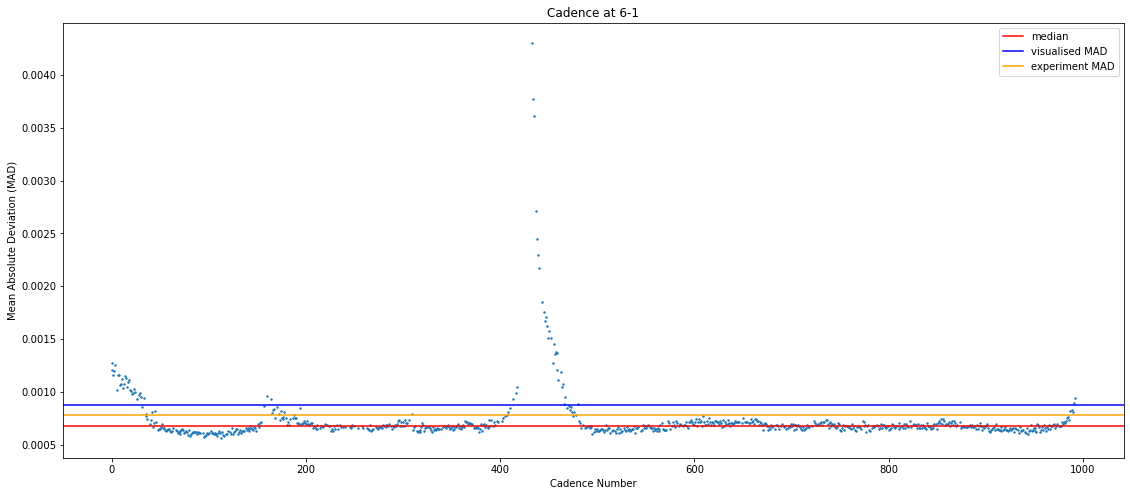

In [19]:
fig,ax = plt.subplots(figsize=(19,8))
ax.scatter(range(0,len(lc.time)), mad_arr, s=2)

ax.axhline(np.nanmedian(mad_arr), c='r',label='median')
ax.axhline(np.nanmedian(mad_arr)+10*np.std(mad_arr[900:950]),c='blue',label='visualised MAD') # 10 sigma threshold
ax.axhline(med_sig_clip + clip*rms_sig_clip, c='orange',label='experiment MAD')
ax.set_xlabel('Cadence Number')
ax.set_ylabel('Mean Absolute Deviation (MAD)')
ax.set_title(f'Cadence at {sec}-{cam}')
ax.legend()
plt.show()

---

Note: the higher `mad_arr` values pose a higher deviation/error. Hence we use a cutoff on `mad_cut` and `mad_cut2`:

In [27]:
mad_cut = mad_arr.values<(np.nanmedian(mad_arr)+10*np.std(mad_arr[900:950])) # removes any values above threshold
mad_cut2 = mad_arr.values<(med_sig_clip + clip*(rms_sig_clip))

In [115]:
mask = np.ones_like(lc.time, dtype=bool)
for i in bad_times:
    newchunk = (lc.time<i[0])|(lc.time>i[1])
    mask = mask & newchunk

### Comparison of plots (with lightcurve `quality = 0`)

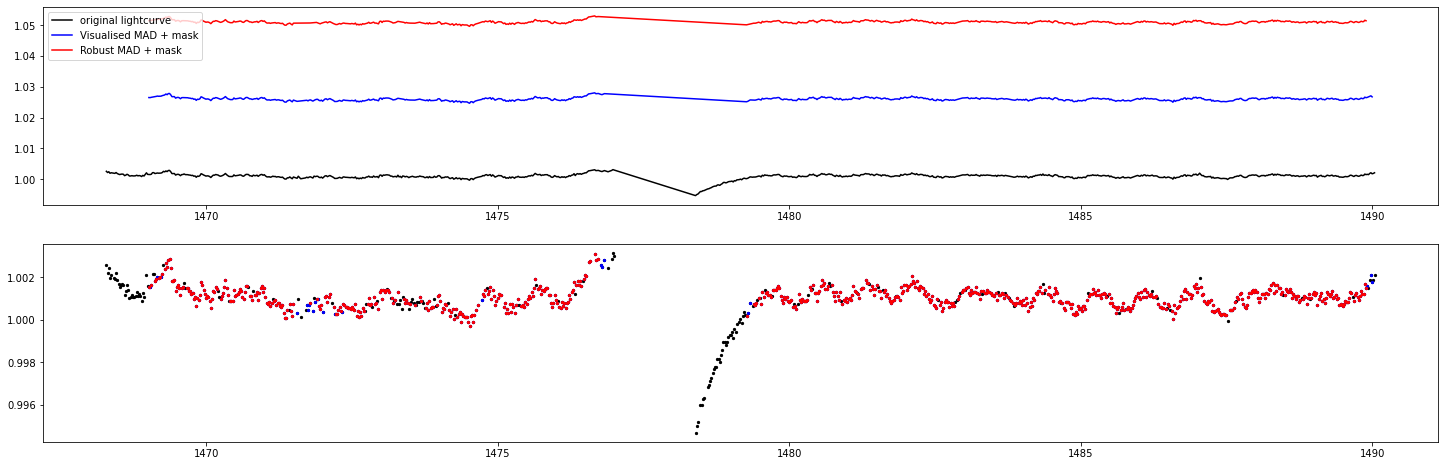

In [116]:
fig,ax = plt.subplots(2,figsize=(25,8))

ax[0].plot(lc['time'][lc.quality==0],lc['normalised PCA'][lc.quality==0],label='original lightcurve',color='black')
ax[0].plot(lc['time'][(lc.quality==0) & mask & mad_cut],lc['normalised PCA'][(lc.quality==0) & mask & mad_cut]+0.025,c='blue',label='Visualised MAD + mask')
ax[0].plot(lc['time'][(lc.quality==0) & mask & mad_cut2],lc['normalised PCA'][(lc.quality==0) & mask & mad_cut2]+0.05,c='red',label='Robust MAD + mask')

ax[1].scatter(lc['time'][lc.quality==0],lc['normalised PCA'][lc.quality==0],label='original lightcurve',s=5,c='black')
ax[1].scatter(lc['time'][(lc.quality==0) & mask & mad_cut],lc['normalised PCA'][(lc.quality==0) & mask & mad_cut],c='blue',label='MAD and mask applied to lightcurve',s=5)
ax[1].scatter(lc['time'][(lc.quality==0) & mask & mad_cut2],lc['normalised PCA'][(lc.quality==0) & mask & mad_cut2],c='red',label='Robust MAD + mask',s=5)
ax[0].legend(loc='upper left')
# ax[1].legend(loc='upper left')
# #plt.ylim(0.9975,1.005)
plt.show()

### Notes:

- The task is to mask the bad quality data in the lightcurves even when the quality flags are set to zero `lc.quality=0`.
- To do so, we use Ethan Kruse's masks, which provide the "bad times" in each sector and we adjust the offset accordingly. These bad times represent an excess of false transits.
- We then use the Median Absolute Deviation (MAD)
- The MAD is used to identify offending cadences, and it is computed for each cadence by Sector/Camera/Detector (SCD). The MAD at a cadence centered at a time, t, for a given set of light curves in a (SCD) is the median value of the set of absolute value deviations from the median flux at that time.
- We compare the "visually obtained" MAD by the XRP with our case of sigma clipping over the whole array. Results are fairly similar, and we will test across other sigma values to determine what is a reasonable cutoff to select.


## Testing how effective our MAD is against the Visualised MAD

#### Comparison plot of SC combination with the median line, Daniel's visualised MAD, and our Sigma Clipped MAD

- A limitation discussed was that the visualised MAD, although very effective, initially focuses on a smaller region of the whole array, eg `[900:950]`, to pick up the standard deviation term, $\sigma_{quiet}$, rather than the whole ensemble. This becomes limited when we want to explore new sectors automatically and perhaps integrate with other data. Below is a plot of the median, visualised MAD and a Sigma Clipped MAD to observe the performance of the Sigma Clipped MAD (clipped at 3 Sigma for this example).

In [117]:
### This code is commented out as it will save the plots

# for i in sectors:
#     for j in cam:
#         mad_arr = mad_df.loc[:len(lc)-1, f"{i}-{j}"] # all FFIs have same length, so this is fine
#         sig_clip = sigma_clip(mad_arr,sigma=m,masked=False)  
#         med_sig_clip = np.nanmedian(sig_clip)
#         rms_sig_clip = sigma_clipped_stats(mad_arr,sigma=m,mask=False)[2]
#         fig,ax = plt.subplots(figsize=(10,5))
#         ax.scatter(range(0,len(lc.time)), mad_arr, s=2)
#         ax.axhline(np.nanmedian(mad_arr), c='r',label='median line')
#         ax.axhline(np.nanmedian(mad_arr)+10*np.std(mad_arr[900:950]),c='blue',label='visualised MAD') # 10 sigma threshold
#         ax.axhline(med_sig_clip + m*(rms_sig_clip), c='orange',label='sigma clipped MAD')
#         threshold = med_sig_clip + m*rms_sig_clip
        
#         mask_for_array = mad_arr<threshold
#         final_clipped_array = mad_arr[mask_for_array]
#         #ax[1].scatter(mad_arr.index[mask], final_clipped_array, s=2)
#         ##ax[1].axhline(np.nanmedian(mad_arr), c='r',label='median')
#         #ax[1].axhline(np.nanmedian(mad_arr)+10*np.std(mad_arr[900:950]),c='blue',label='visualised MAD') # 10 sigma threshold
#         #ax[1].axhline(med_sig_clip + clip*rms_sig_clip, c='orange',label='experiment MAD')
#         #print(f"{med_sig_clip + m*(np.std(sig_clip))} is the stddev using `np.std(sig_clip)`")
#         #print(f"{med_sig_clip + m*(rms_sig_clip)} is the stdddev using `sigma_clipped_stats(mad_arr,sigma=m)[2]`")

#         ax.set_title(f"{i}-{j}")
#         ax.legend()
#         ax.set_ylim([0.3*np.nanmedian(mad_arr),2.5*np.nanmedian(mad_arr)])
#         #fig.savefig(f"MAD figs/{i}-{j} at {m} sigma")
        
    

### Now, I want to plot the points that got kept

Plotting the cadence vs the MAD, and the MAD where the points are underneath the specified threshold.
- The data now agrees; previously, there was a big discrepancy between the numbers but we find out that there were many NaNs that were not accounted for. This was fixed by using `np.isnan(mad_arr).sum()` to find the NaN's and discard them from the data. Why the NaNs are present we are not sure -> a question to ask. 

#### The following is for the case of 3 sigma on our Sigma Clipped MAD.

13.974358974358974 is the percentage of data discarded, corresponding to 109 data points out of 993


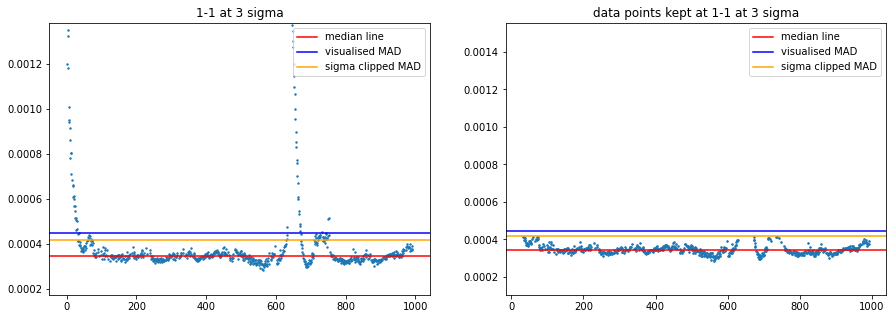

11.673151750972762 is the percentage of data discarded, corresponding to 90 data points out of 993


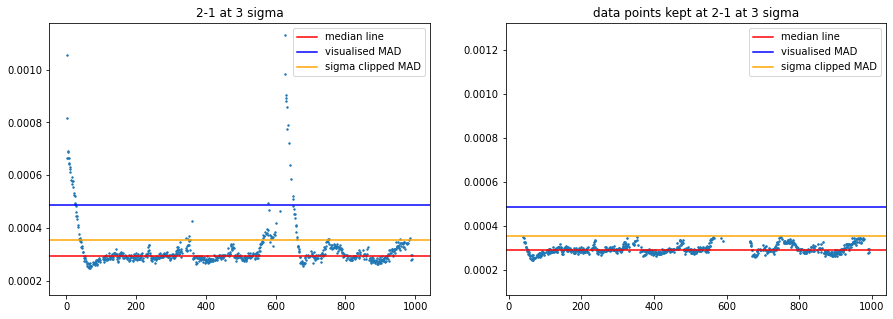

7.822085889570553 is the percentage of data discarded, corresponding to 51 data points out of 993


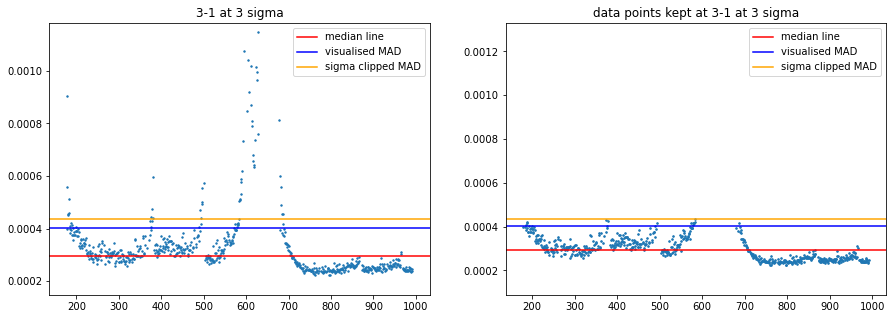

12.1251629726206 is the percentage of data discarded, corresponding to 93 data points out of 993


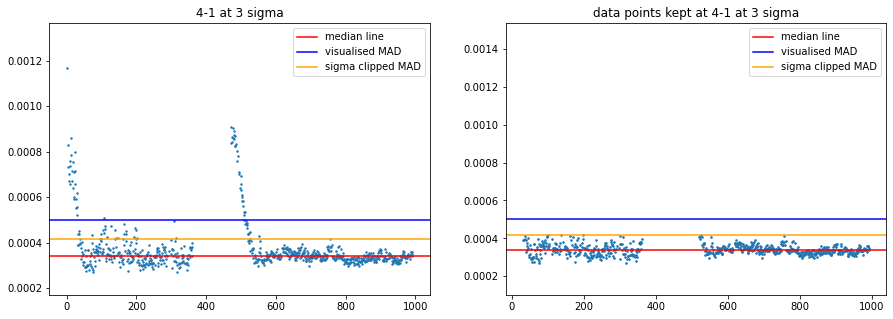

9.70556161395856 is the percentage of data discarded, corresponding to 89 data points out of 993


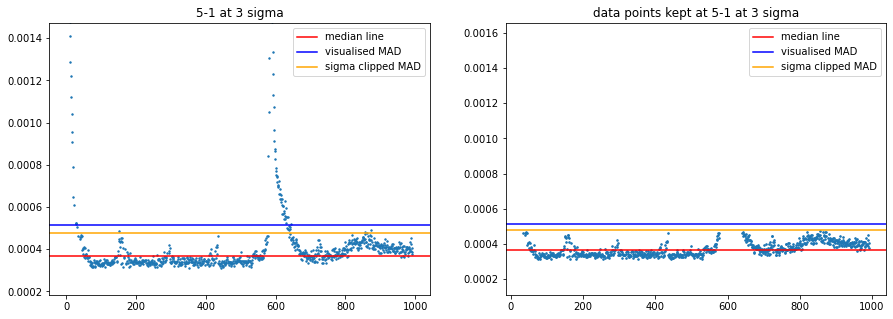

10.952380952380953 is the percentage of data discarded, corresponding to 92 data points out of 993


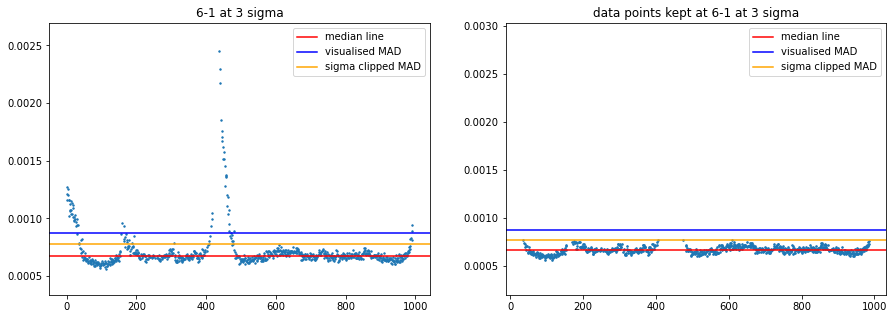

9.615384615384617 is the percentage of data discarded, corresponding to 80 data points out of 993


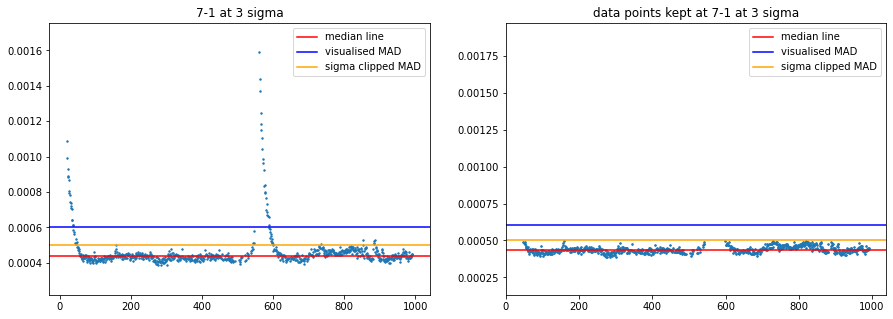

13.922518159806296 is the percentage of data discarded, corresponding to 115 data points out of 993


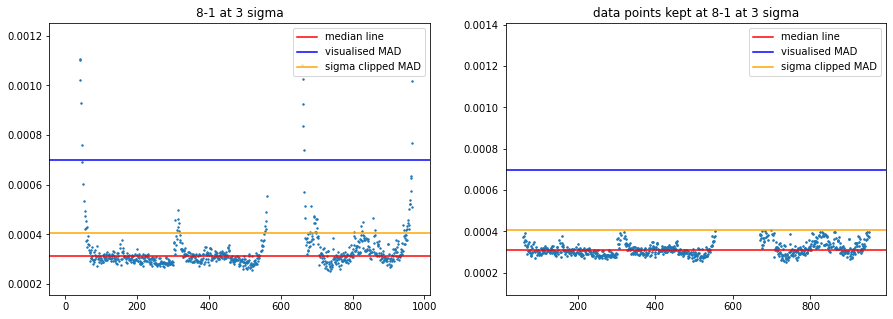

16.94915254237288 is the percentage of data discarded, corresponding to 150 data points out of 993


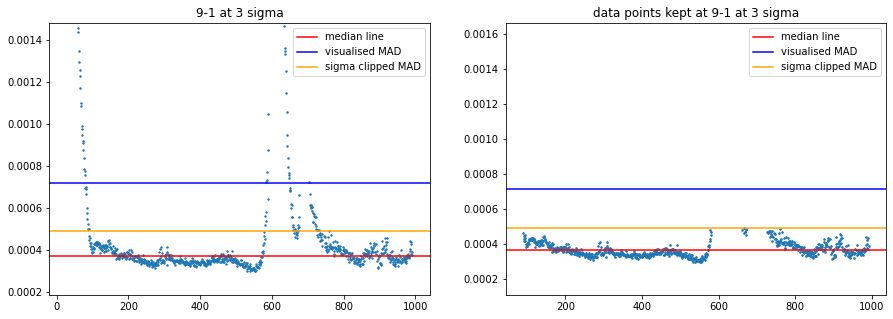

15.835140997830802 is the percentage of data discarded, corresponding to 146 data points out of 993


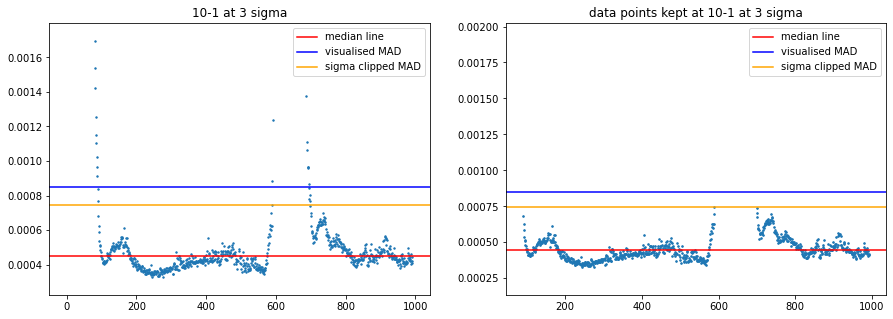

18.933333333333334 is the percentage of data discarded, corresponding to 142 data points out of 993


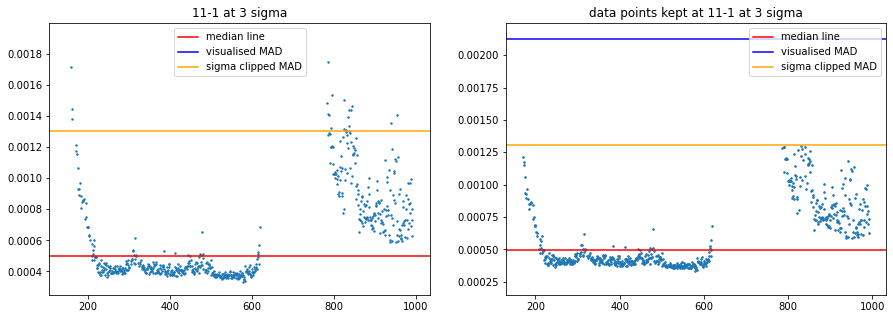

21.06703146374829 is the percentage of data discarded, corresponding to 154 data points out of 993


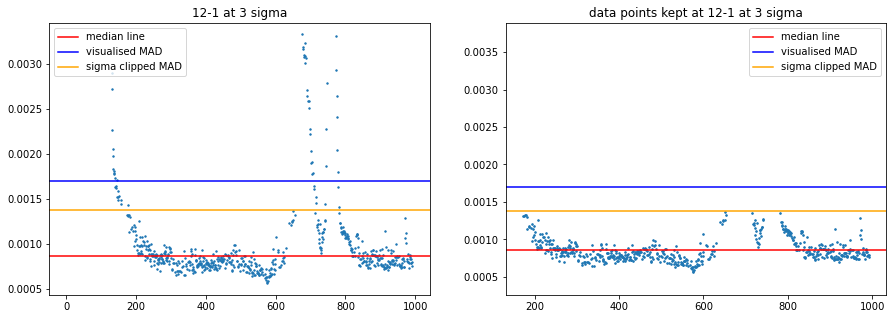

20.30696576151122 is the percentage of data discarded, corresponding to 172 data points out of 993


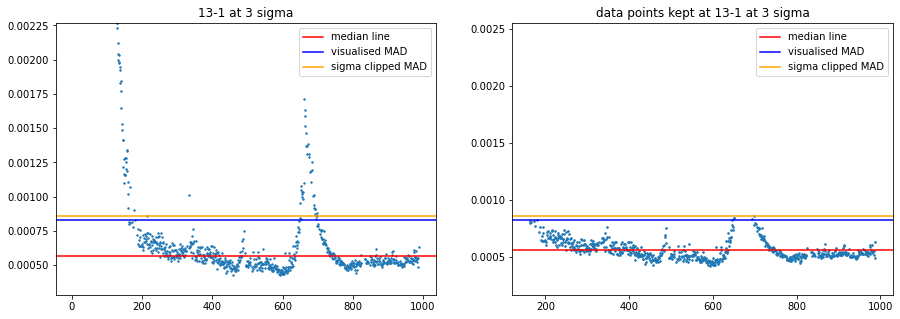

9.640102827763496 is the percentage of data discarded, corresponding to 75 data points out of 993


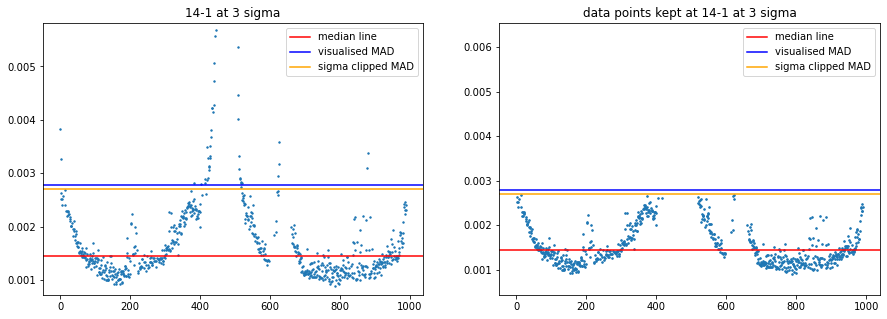

15.0 is the percentage of data discarded, corresponding to 123 data points out of 993


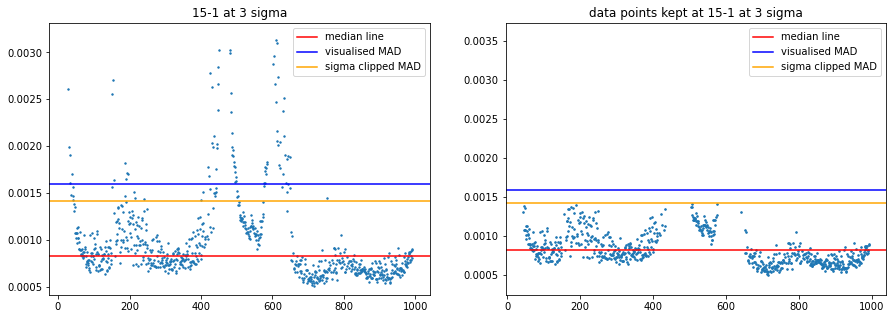

9.45945945945946 is the percentage of data discarded, corresponding to 84 data points out of 993


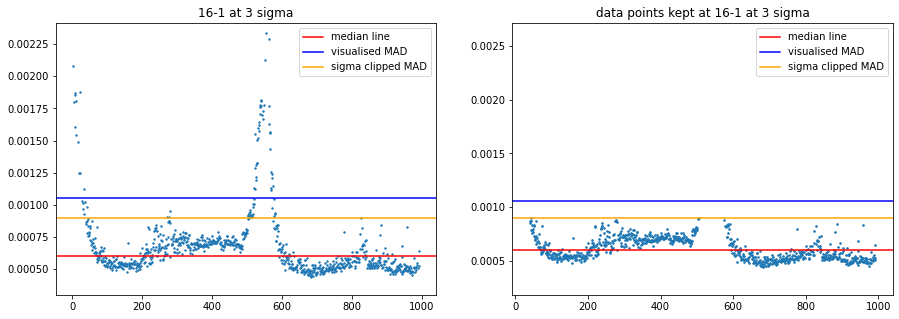

11.504424778761061 is the percentage of data discarded, corresponding to 91 data points out of 993


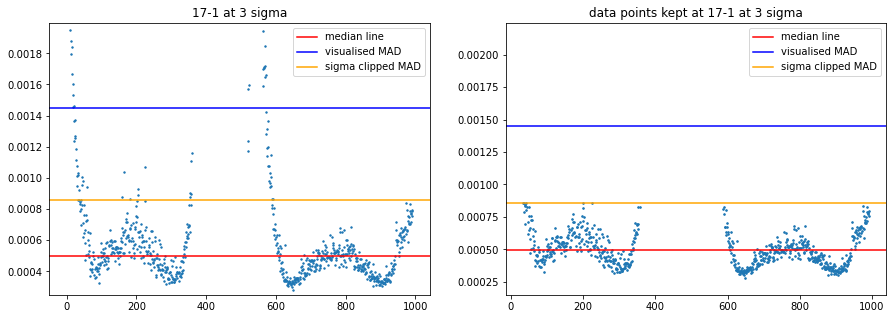

12.240184757505773 is the percentage of data discarded, corresponding to 106 data points out of 993


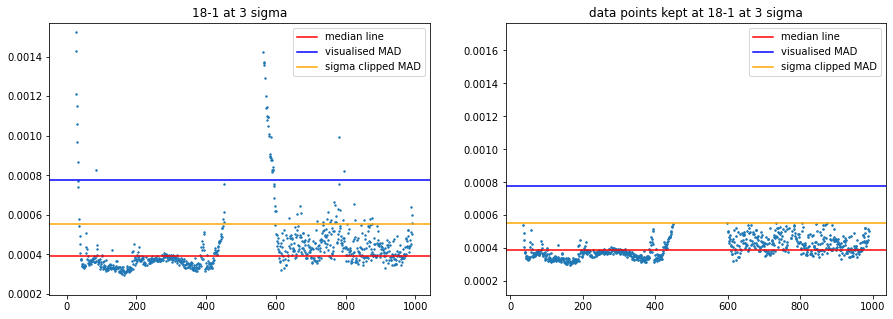

9.331476323119778 is the percentage of data discarded, corresponding to 67 data points out of 993


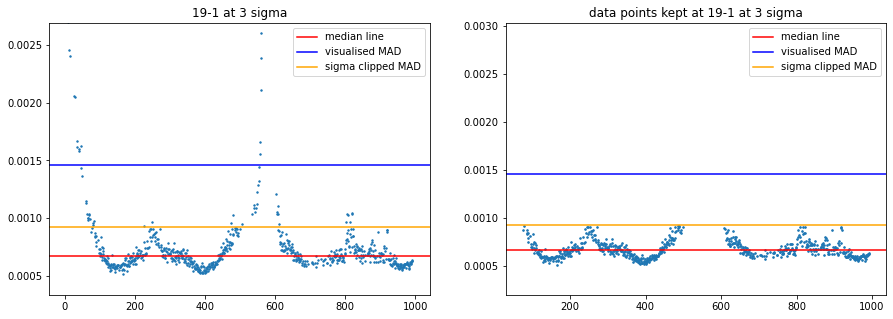

9.4151212553495 is the percentage of data discarded, corresponding to 66 data points out of 993


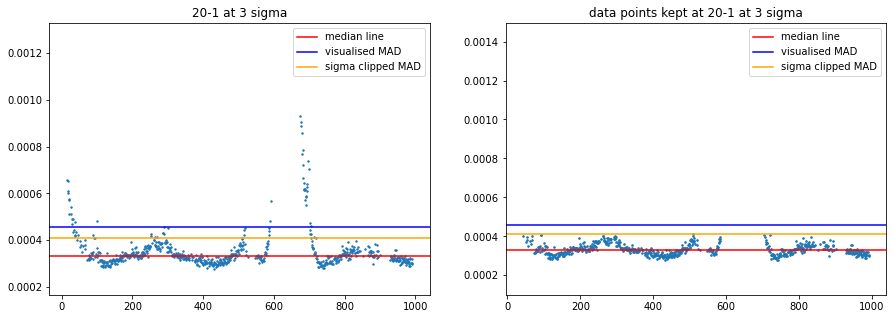

12.83068783068783 is the percentage of data discarded, corresponding to 97 data points out of 993


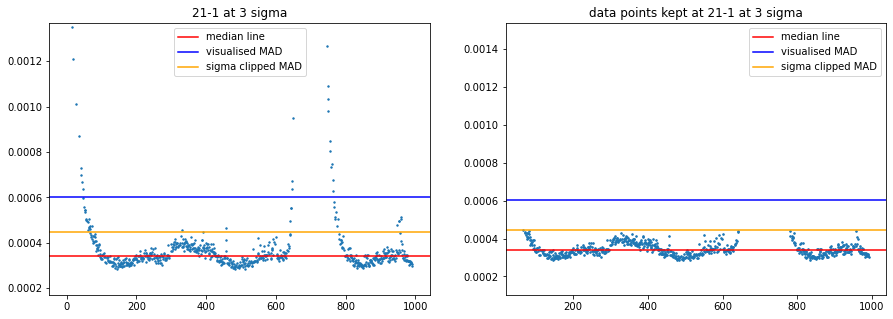

19.670050761421322 is the percentage of data discarded, corresponding to 155 data points out of 993


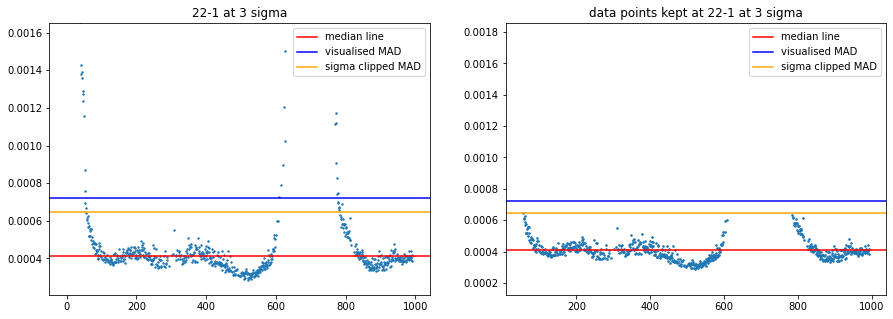

25.37313432835821 is the percentage of data discarded, corresponding to 136 data points out of 993


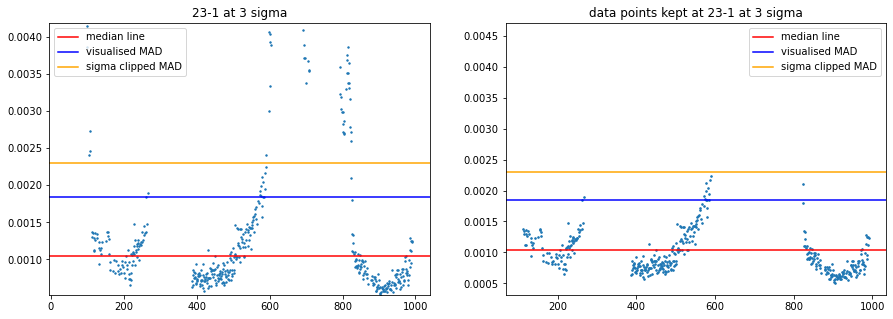

12.0 is the percentage of data discarded, corresponding to 84 data points out of 993


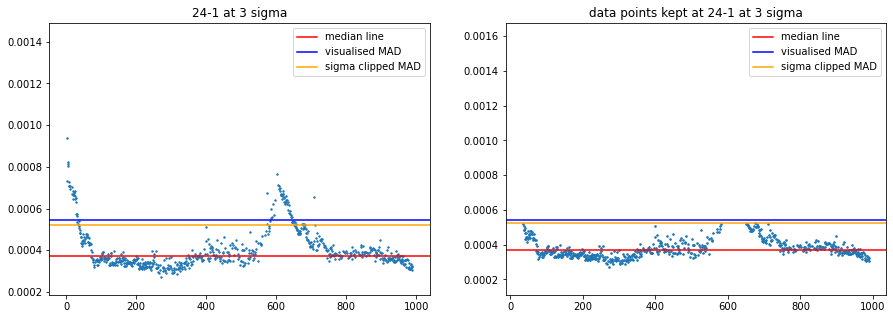

9.738372093023257 is the percentage of data discarded, corresponding to 67 data points out of 993


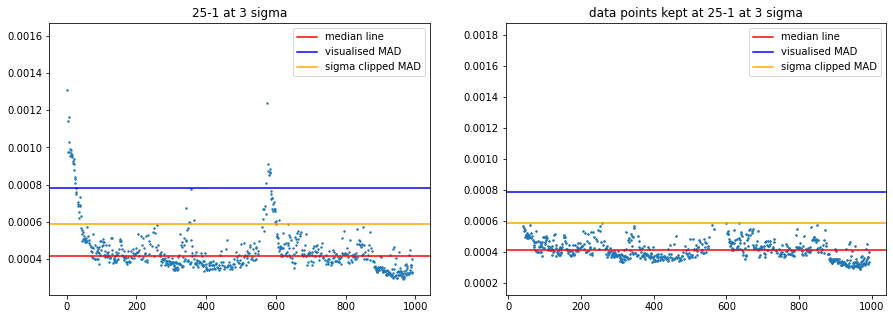

7.544378698224852 is the percentage of data discarded, corresponding to 51 data points out of 993


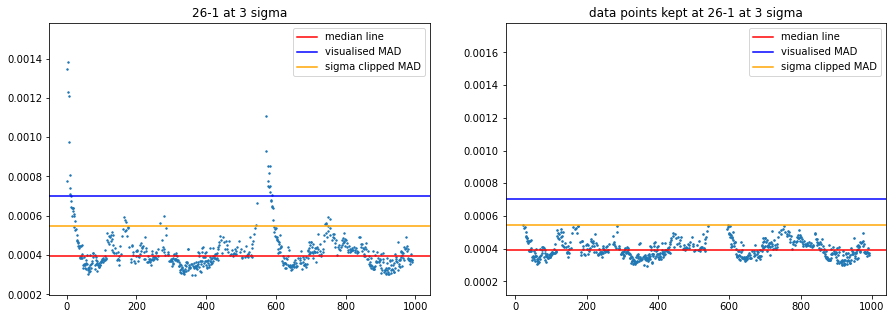

In [118]:
sectors = np.arange(1,27,1)
cam = [1,2,3,4]
m = 3
# k = list length of lightcurves at each sector
for i in sectors:
    for j in cam:
        mad_arr = mad_df.loc[:len(lc)-1, f"{i}-{j}"] # all FFIs have same length, so this is fine
        sig_clip = sigma_clip(mad_arr,sigma=m,masked=False)  
        med_sig_clip = np.nanmedian(sig_clip)
        rms_sig_clip = np.nanstd(sig_clip)
        fig,(ax1,ax2) = plt.subplots(ncols=2,figsize=(15,5))
        ax1.scatter(range(0,len(lc.time)), mad_arr, s=2)
        ax1.axhline(np.nanmedian(mad_arr), c='r',label='median line')
        ax1.axhline(np.nanmedian(mad_arr)+10*np.std(mad_arr[900:950]),c='blue',label='visualised MAD') # 10 sigma threshold
        ax1.axhline(med_sig_clip + m*(rms_sig_clip), c='orange',label='sigma clipped MAD')   
        #ax1.axhline(med_sig_clip - m*(rms_sig_clip), c='orange',label='sigma clipped MAD')  
        ax1.set_title(f"{i}-{j} at {m} sigma")
        ax1.legend()
        ax1.set_ylim([0.5*np.nanmedian(mad_arr),4*np.nanmedian(mad_arr)])
        np.isnan(mad_arr).sum()
        threshold = med_sig_clip + m*(rms_sig_clip)
        apply_mask = mad_arr<threshold
        final = mad_arr[apply_mask]
        print(f"{(len(apply_mask) -  np.isnan(mad_arr).sum() - len(final))/(len(apply_mask) - np.isnan(mad_arr).sum()) * 100} is the percentage of data discarded, corresponding to {len(apply_mask) - len(final)- np.isnan(mad_arr).sum()} data points out of {len(apply_mask)}")

        
        ax2.axhline(np.nanmedian(mad_arr), c='r',label='median line')
        ax2.axhline(np.nanmedian(mad_arr)+10*np.std(mad_arr[900:950]),c='blue',label='visualised MAD') # 10 sigma threshold
        ax2.axhline(med_sig_clip + m*(rms_sig_clip), c='orange',label='sigma clipped MAD')
        ax2.scatter(mad_arr.index[apply_mask],mad_arr[apply_mask],s=2.5)
        ax2.set_ylim([0.3*np.nanmedian(mad_arr),2.5*np.nanmedian(mad_arr)])
        ax2.set_title(f"data points kept at {i}-{j} at {m} sigma")
        ax2.legend()
        ax2.set_ylim([0.3*np.nanmedian(mad_arr),4.5*np.nanmedian(mad_arr)])

        #fig.savefig(f"MAD figs/{i}-{j} at {m} sigma")
        plt.show()
        break
        

## A plot to visualise the fraction of data discarded with respect to the Sigma cutoff

To recap, the threshold we use for our own research is: 

$$\text{threshold} = \texttt{med}(\text{MAD}) + m*\sigma$$

where $m$ is the sigma chosen, and $\sigma$ is the standard deviation of sigma clipped `mad_arr`.

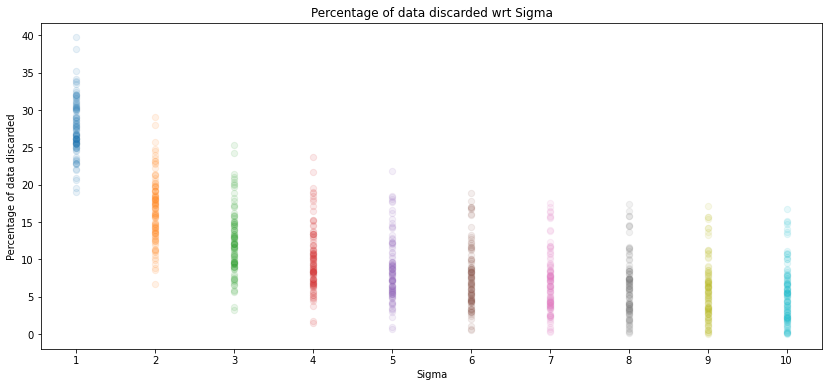

In [92]:
plt.figure(figsize=(14,6))
sectors = np.arange(1,27,1)
cam = [1,2,3,4]
clip = np.arange(1,11,1)
for i in sectors:
    for j in cam:
        for k in clip:
            mad_arr = mad_df.loc[:len(lc)-1, f"{i}-{j}"] # all FFIs have same length, so this is fine
            sig_clip = sigma_clip(mad_arr,sigma=m,masked=False) # masks kept False to return under threshold and perform clipping on that.
            med_sig_clip = np.nanmedian(sig_clip)
            rms_sig_clip = np.nanstd(sig_clip)
            threshold = med_sig_clip + k*(rms_sig_clip)
            apply_mask = mad_arr<threshold
            final = mad_arr[apply_mask]
            percent_discard = (len(apply_mask) -  np.isnan(mad_arr).sum() - len(final))/(len(apply_mask) - np.isnan(mad_arr).sum())

            plt.scatter(k, percent_discard * 100,label=f'{sec}-{cam} at {k} clip',alpha=0.1,s=40)
            #plt.legend()
            plt.title('Percentage of data discarded wrt Sigma')
            plt.ylabel('Percentage of data discarded')
            plt.xlabel('Sigma')
            plt.xticks(np.arange(1,11,1))


Notes: It seems like a reasonable cut off is actually 3 sigma, so what we have tested earlier. It cuts off a reasonable amount of data whilst also retaining a good amount of data to contribute to finding transits (as seen above in the Comparison of Plots section.

- However, 4 sigma also seems like a reasonable cutoff point. 
- The next steps are to experiment with 3 and 4 sigma thresholds and see if we want to be a bit lenient and keep some extra data, or act a bit more rigid with our selected threshold. The thinking is that at 4 sigma, we will allow more "maybeTransit" and filter accordingly. But if we find that there are too many "maybeTransit" near the downlinks or start/ends of lightcurves, we will cut the threshold down to 3 sigma instead.

### A description to which MAD threshold is lower for each SC combination

In [93]:
# for i in range(1,27):
#     for j in cam:
#         if med_sig_clips[i] < med_arrs[j]:
#             print(f"Sector {i}, Camera {j}, Sigma Clipped MAD has a lower threshold than visualised MAD.")
#         elif round(med_sig_clips[i],9) == round(med_arrs[j],9):
#             print(f"Sector {i}, Camera {j}, roughly the same.")
#         else:
#             print(f"Sector {i}, Camera {j}, visualised MAD has lower threshold.")

This line takes the median of the data points that were under the threshold:

In [94]:
#np.nanmedian(sig_clip.data[sig_clip.mask == False]) # basically the same if mask = False. Why we use mask = True is to match the array lengths

This line takes the median of the whole dataset (even if some were above the threshold)

## Plotting all the sigma's onto one plot.

Managed to plot the lines. Issue in this code is that the clipped array, so `med_sig_clip` and `rms_sig_clip` is based off `sig_clip` clipped to 3 sigma, which is not completely reflective of the accuracy of the threshold. This needs changing.

In [95]:
# sectors = np.arange(1,27,1)
# cam = [1,2,3,4]
# m = np.arange(1,11,1)

# for i in sectors:
#     for j in cam:
#         mad_arr = mad_df.loc[:len(lc)-1, f"{i}-{j}"] # all FFIs have same length, so this is fine
#         sig_clip = sigma_clip(mad_arr,sigma=m[2],masked=False)  
#         med_sig_clip = np.nanmedian(sig_clip)
#         rms_sig_clip = np.nanstd(sig_clip)
#         fig,ax1 = plt.subplots(ncols=1,figsize=(15,5))
#         ax1.scatter(range(0,len(lc.time)), mad_arr, s=2)
#         ax1.axhline(np.nanmedian(mad_arr), c='r',label='median line')
#         ax1.axhline(np.nanmedian(mad_arr)+10*np.std(mad_arr[900:950]),c='blue',label='visualised MAD') # 10 sigma threshold
#         for k in m:
#             ax1.axhline(med_sig_clip + k*(rms_sig_clip),label=f'sigma clipped MAD at {k} sigma') 
# #         ax1.axhline(med_sig_clip + m[1]*(rms_sig_clip), c='orange',label=f'sigma clipped MAD at {m[1]}') 
# #         ax1.axhline(med_sig_clip + m[2]*(rms_sig_clip), c='orange',label=f'sigma clipped MAD at {m[2]}') 
# #         ax1.axhline(med_sig_clip + m[3]*(rms_sig_clip), c='orange',label=f'sigma clipped MAD at {m[3]}') 
# #         ax1.axhline(med_sig_clip + m[4]*(rms_sig_clip), c='orange',label=f'sigma clipped MAD at {m[4]}') 
# #         ax1.axhline(med_sig_clip + m[5]*(rms_sig_clip), c='orange',label=f'sigma clipped MAD at {m[5]}') 
# #         ax1.axhline(med_sig_clip + m[6]*(rms_sig_clip), c='orange',label=f'sigma clipped MAD at {m[6]}')
# #         ax1.axhline(med_sig_clip + m[7]*(rms_sig_clip), c='orange',label=f'sigma clipped MAD at {m[7]}') 
# #         ax1.axhline(med_sig_clip + m[8]*(rms_sig_clip), c='orange',label=f'sigma clipped MAD at {m[8]}') 
# #         ax1.axhline(med_sig_clip + m[9]*(rms_sig_clip), c='orange',label=f'sigma clipped MAD at {m[9]}') 
#         #ax1.axhline(med_sig_clip - m*(rms_sig_clip), c='orange',label='sigma clipped MAD')  
#         ax1.set_title(f"{i}-{j} at {m[2]} sigma")
#         ax1.legend()
#         ax1.set_ylim([0.5*np.nanmedian(mad_arr),4*np.nanmedian(mad_arr)])
#         break

---

### Where are the NaNs wrt the cadences

In [96]:
sec = int(filename.split('_')[2])
cam = store[4]
mad_arr = mad_df.loc[:len(lc)-1, f"{sec}-{cam}"]


IndexError: list index out of range

In [ ]:
clip = 3
sig_test_2 = sigma_clip(mad_arr,sigma=clip,masked=False)
med_sig_clip_2 = np.nanmedian(sig_test_2)
rms_sig_clip_2 = np.nanstd(sig_test_2)
mad_arr_filled = mad_arr.fillna(0)

In [ ]:
fig,ax = plt.subplots(figsize=(19,6))
ax.scatter(range(0,len(lc.time)), mad_arr_filled, s=5)
ax.axhline(np.nanmedian(mad_arr), c='r',label='median')
ax.axhline(np.nanmedian(mad_arr)+10*np.std(mad_arr[900:950]),c='blue',label='visualised MAD') # 10 sigma threshold
ax.axhline(med_sig_clip_2 + clip*rms_sig_clip_2, c='orange',label='experiment MAD')
ax.set_xlabel('Cadence Number')
ax.set_ylabel('Mean Absolute Deviation (MAD)')
ax.set_title(f'Cadence at {sec}-{cam}')
ax.legend()
plt.show()

---

## Exploring the NaNs

As mentioned above, we get a peculiar amount of NaNs. This could be a Pandas thing, where the columns just fill NaNs where the data points aren't equal? Something to explore and ask about. We want to see where the NaNs fall in place wrt the rest of the cadences, so we use `.fillna(0)` to see where they would lie in the MAD array.

For all sectors:

In [ ]:
sectors = np.arange(1,27,1)
cam = [1,2,3,4]
m = 3

for i in sectors:
    for j in cam:
        mad_arr = mad_df.loc[:len(lc)-1, f"{i}-{j}"] # all FFIs have same length, so this is fine
        sig_clip = sigma_clip(mad_arr,sigma=m,masked=False)  
        med_sig_clip = np.nanmedian(sig_clip)
        rms_sig_clip = np.nanstd(sig_clip)
        mad_arr_filled = mad_arr.fillna(0)
        
        fig,ax = plt.subplots(figsize=(15,5))
        ax.scatter(range(0,len(lc.time)), mad_arr_filled, s=7)
        ax.axhline(np.nanmedian(mad_arr), c='r',label='median line')
        ax.axhline(np.nanmedian(mad_arr)+10*np.std(mad_arr[900:950]),c='blue',label='visualised MAD') # 10 sigma threshold
        ax.axhline(med_sig_clip + m*(rms_sig_clip), c='orange',label='sigma clipped MAD')   
        #ax1.axhline(med_sig_clip - m*(rms_sig_clip), c='orange',label='sigma clipped MAD')  
        ax.set_title(f"{i}-{j} at {m} sigma")
        ax.legend()
        plt.show()


In [ ]:
len(mad_df.loc[:len(lc)-1, f"{3}-{1}"])

In [ ]:
len(lc)

---

## Revisited

In [135]:
df = pd.read_json("./data/Sectors_MAD.json")

In [136]:
sub_meds = np.nanmedian(df.iloc[900:950,:],axis=0)
sub_stdevs = np.nanstd(df.iloc[900:950,:],axis=0)

In [123]:
median = []
for i in df.columns:
    median.append(np.nanmedian(sigma_clip(df[i],sigma=clip,masked=False)))

In [125]:
rms = []
for i in df.columns:
    rms.append(np.nanstd(sigma_clip(df[i],sigma=clip,masked=False)))

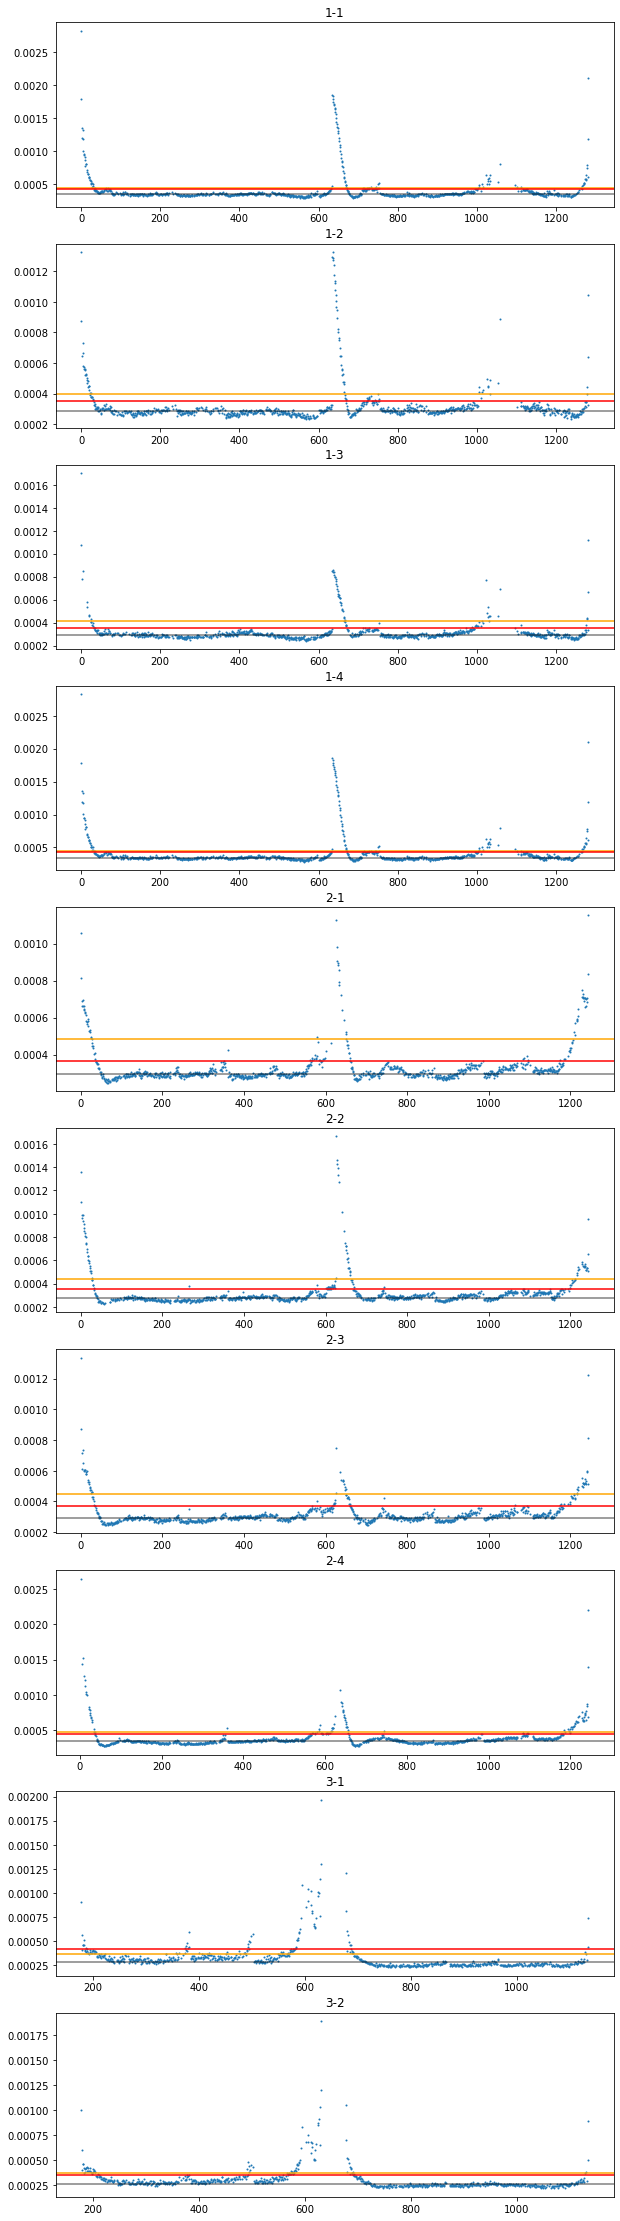

In [145]:
fig, ax = plt.subplots(10,figsize=(10,40))
for i, col in enumerate(df.columns[:10]):
    ax[i].scatter(df.index,df.loc[:,col],s=1)
    ax[i].axhline(median[i],color="black",alpha=.5)
    ax[i].axhline(sub_stdevs[i]*10+sub_meds[i], color="orange")
    ax[i].axhline(median[i]+3*rms[i], color="red")
    #ax[i].axhline(full_meds[i],color="red")
    ax[i].set_title(col)

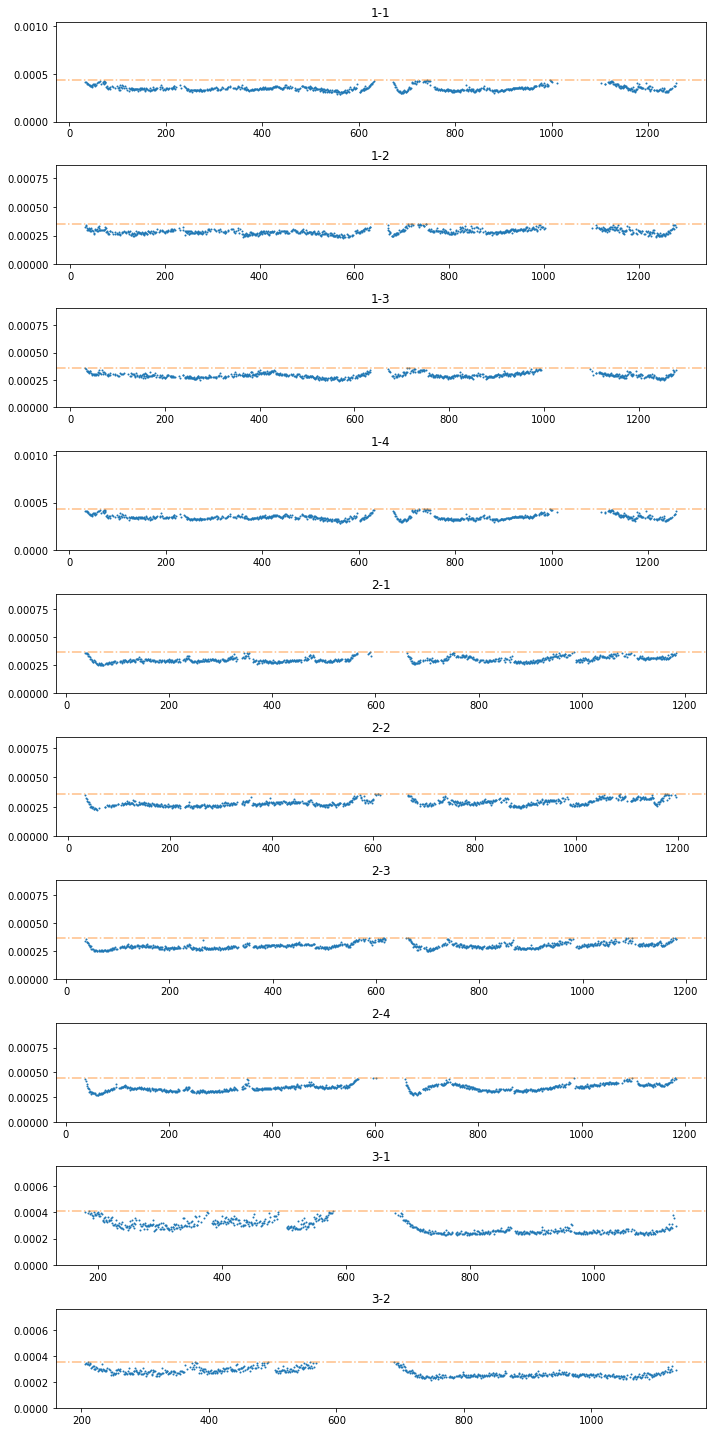

In [140]:
fig, ax = plt.subplots(10,figsize=(10,20),tight_layout=True)
for i, col in enumerate(df.columns[:10]):
    threshold = median[i]+3*rms[i]
    data = df.loc[:,col]
    mask = data<threshold
    data = data[mask]
    ax[i].scatter(df.index[mask],data,s=1)
    ax[i].axhline(threshold,linestyle="dashdot", alpha=.5, color="tab:orange")
    ax[i].set_title(col)
    ax[i].set_ylim(0,3*sub_meds[i])